In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

seed = 14
torch.manual_seed(seed)
np.random.seed(seed)

# Transformacja do tensora (niezbędna dla sieci)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Pobranie danych treningowych i testowych
train_dataset = torchvision.datasets.FashionMNIST("./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST("./data", train=False, download=True, transform=transform)

# Dataloadery
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Sprawdzenie kształtu danych
for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([16, 1, 28, 28])
Shape of y: torch.Size([16]) torch.int64


In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=512, num_classes=10, num_hidden_layers=1):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        
        layers = []
        if num_hidden_layers == 0:
            # Sieć jednowarstwowa (tylko warstwa wyjściowa)
            layers.append(nn.Linear(input_size, num_classes))
        else:
            # Sieć dwuwarstwowa (warstwa ukryta + wyjściowa)
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Linear(hidden_size, num_classes))
            
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [14]:
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    loss_history = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)

            # Obliczenie błędu
            pred = model(X)
            loss = criterion(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        
    return loss_history

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            predicted = pred.argmax(1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
            
    accuracy = correct / total
    return accuracy

--- Eksperyment 1: Liczba neuronów ---
Training 1-layer network (Linear)...
Epoch 1/10, Loss: 0.5278
Epoch 1/10, Loss: 0.5278
Epoch 2/10, Loss: 0.4576
Epoch 2/10, Loss: 0.4576
Epoch 3/10, Loss: 0.4430
Epoch 3/10, Loss: 0.4430
Epoch 4/10, Loss: 0.4375
Epoch 4/10, Loss: 0.4375
Epoch 5/10, Loss: 0.4335
Epoch 5/10, Loss: 0.4335
Epoch 6/10, Loss: 0.4301
Epoch 6/10, Loss: 0.4301
Epoch 7/10, Loss: 0.4222
Epoch 7/10, Loss: 0.4222
Epoch 8/10, Loss: 0.4209
Epoch 8/10, Loss: 0.4209
Epoch 9/10, Loss: 0.4193
Epoch 9/10, Loss: 0.4193
Epoch 10/10, Loss: 0.4172
Epoch 10/10, Loss: 0.4172
1-layer Accuracy: 0.8348
Training 2-layer network with 4 hidden neurons...
1-layer Accuracy: 0.8348
Training 2-layer network with 4 hidden neurons...
Epoch 1/10, Loss: 0.8082
Epoch 1/10, Loss: 0.8082
Epoch 2/10, Loss: 0.5951
Epoch 2/10, Loss: 0.5951
Epoch 3/10, Loss: 0.5621
Epoch 3/10, Loss: 0.5621
Epoch 4/10, Loss: 0.5447
Epoch 4/10, Loss: 0.5447
Epoch 5/10, Loss: 0.5370
Epoch 5/10, Loss: 0.5370
Epoch 6/10, Loss: 0.53

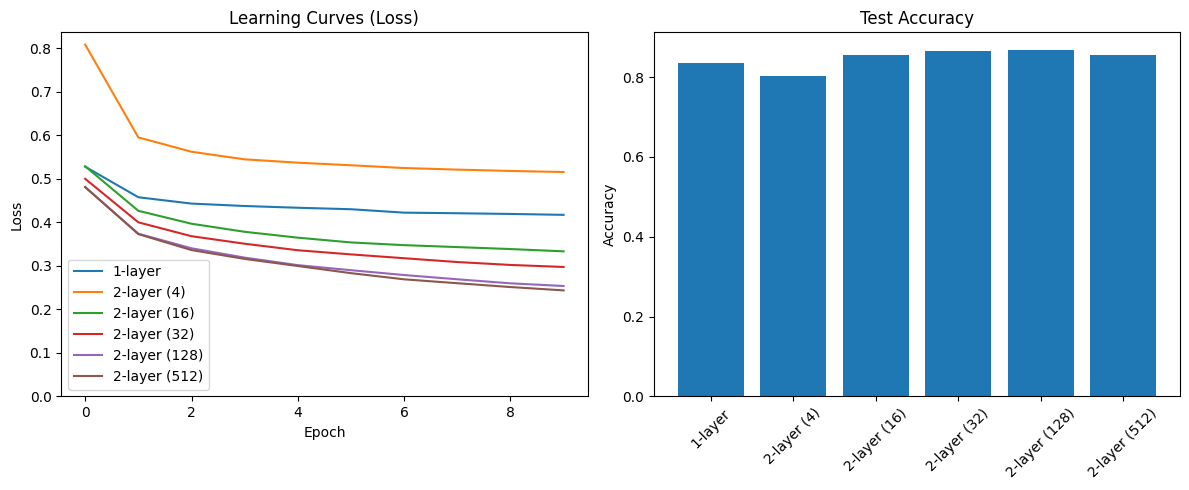

In [15]:
# Eksperyment 1: Liczba neuronów w warstwie ukrytej
hidden_sizes = [4, 16, 32, 128, 512]
results_exp1 = {}

print("--- Eksperyment 1: Liczba neuronów ---")

# 1. Sieć jednowarstwowa (0 warstw ukrytych)
print(f"Training 1-layer network (Linear)...")
model = NeuralNetwork(num_hidden_layers=0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_hist = train_model(model, train_loader, criterion, optimizer, epochs=10)
acc = evaluate_model(model, test_loader)
results_exp1['1-layer'] = {'loss': loss_hist, 'acc': acc}
print(f"1-layer Accuracy: {acc:.4f}")

# 2. Sieć dwuwarstwowa z różną liczbą neuronów
for h_size in hidden_sizes:
    print(f"Training 2-layer network with {h_size} hidden neurons...")
    model = NeuralNetwork(hidden_size=h_size, num_hidden_layers=1).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_hist = train_model(model, train_loader, criterion, optimizer, epochs=10)
    acc = evaluate_model(model, test_loader)
    results_exp1[f'2-layer ({h_size})'] = {'loss': loss_hist, 'acc': acc}
    print(f"2-layer ({h_size}) Accuracy: {acc:.4f}")

# Wizualizacja
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for name, res in results_exp1.items():
    plt.plot(res['loss'], label=name)
plt.title("Learning Curves (Loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(bottom=0)
plt.legend()

plt.subplot(1, 2, 2)
names = list(results_exp1.keys())
accs = [results_exp1[n]['acc'] for n in names]
plt.bar(names, accs)
plt.title("Test Accuracy")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Wnioski - Eksperyment 1
*   **Sieć jednowarstwowa (liniowa)** osiąga przyzwoity wynik, ale zazwyczaj gorszy od sieci głębszych, ponieważ nie potrafi modelować nieliniowych zależności.
*   **Mała liczba neuronów (np. 4)** w warstwie ukrytej działa jak "wąskie gardło" (bottleneck), ograniczając przepływ informacji i prowadząc do underfittingu.
*   **Zwiększanie liczby neuronów** (do 128, 512) zazwyczaj poprawia dokładność, pozwalając sieci nauczyć się bardziej złożonych cech. Jednak zbyt duża liczba może prowadzić do overfittingu (choć przy 5 epokach może to nie być jeszcze widoczne) i wydłuża czas obliczeń.


--- Eksperyment 2: Rozmiar batcha ---
Training with batch size 16...
Epoch 1/10, Loss: 0.4823
Epoch 1/10, Loss: 0.4823
Epoch 2/10, Loss: 0.3739
Epoch 2/10, Loss: 0.3739
Epoch 3/10, Loss: 0.3412
Epoch 3/10, Loss: 0.3412
Epoch 4/10, Loss: 0.3189
Epoch 4/10, Loss: 0.3189
Epoch 5/10, Loss: 0.3015
Epoch 5/10, Loss: 0.3015
Epoch 6/10, Loss: 0.2884
Epoch 6/10, Loss: 0.2884
Epoch 7/10, Loss: 0.2784
Epoch 7/10, Loss: 0.2784
Epoch 8/10, Loss: 0.2680
Epoch 8/10, Loss: 0.2680
Epoch 9/10, Loss: 0.2580
Epoch 9/10, Loss: 0.2580
Epoch 10/10, Loss: 0.2507
Epoch 10/10, Loss: 0.2507
Batch 16 Accuracy: 0.8782
Training with batch size 64...
Batch 16 Accuracy: 0.8782
Training with batch size 64...
Epoch 1/10, Loss: 0.4993
Epoch 1/10, Loss: 0.4993
Epoch 2/10, Loss: 0.3817
Epoch 2/10, Loss: 0.3817
Epoch 3/10, Loss: 0.3447
Epoch 3/10, Loss: 0.3447
Epoch 4/10, Loss: 0.3194
Epoch 4/10, Loss: 0.3194
Epoch 5/10, Loss: 0.3000
Epoch 5/10, Loss: 0.3000
Epoch 6/10, Loss: 0.2873
Epoch 6/10, Loss: 0.2873
Epoch 7/10, Lo

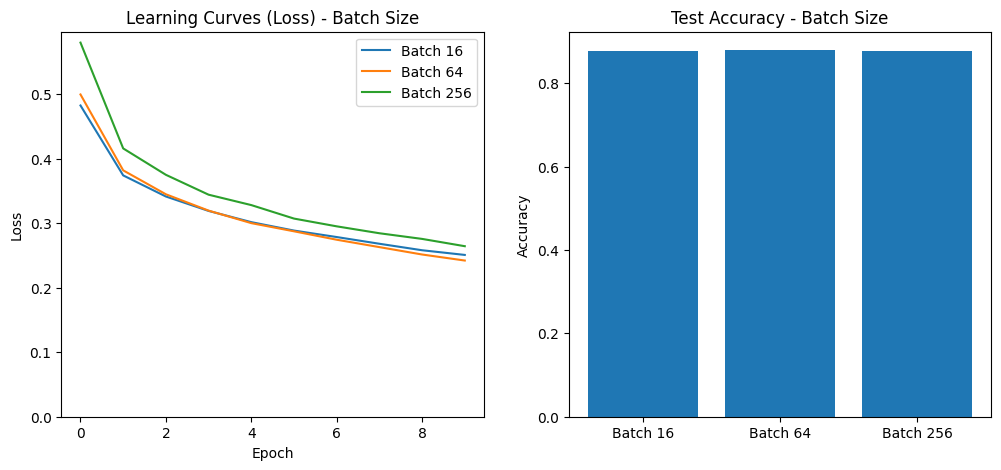

In [16]:
# Eksperyment 2: Rozmiar batcha
batch_sizes = [16, 64, 256]
results_exp2 = {}
fixed_hidden_size = 128 # Wybieramy jedną architekturę dla porównania

print("\n--- Eksperyment 2: Rozmiar batcha ---")

for b_size in batch_sizes:
    print(f"Training with batch size {b_size}...")
    # Musimy utworzyć nowy DataLoader dla każdego rozmiaru batcha
    train_loader_b = torch.utils.data.DataLoader(train_dataset, batch_size=b_size, shuffle=True)
    
    model = NeuralNetwork(hidden_size=fixed_hidden_size, num_hidden_layers=1).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    loss_hist = train_model(model, train_loader_b, criterion, optimizer, epochs=10)
    acc = evaluate_model(model, test_loader)
    
    results_exp2[f'Batch {b_size}'] = {'loss': loss_hist, 'acc': acc}
    print(f"Batch {b_size} Accuracy: {acc:.4f}")

# Wizualizacja
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for name, res in results_exp2.items():
    plt.plot(res['loss'], label=name)
plt.title("Learning Curves (Loss) - Batch Size")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(bottom=0)
plt.legend()

plt.subplot(1, 2, 2)
names = list(results_exp2.keys())
accs = [results_exp2[n]['acc'] for n in names]
plt.bar(names, accs)
plt.title("Test Accuracy - Batch Size")
plt.ylabel("Accuracy")
plt.show()

### Wnioski - Eksperyment 2
*   **Mały batch (16)**: Powoduje częstsze aktualizacje wag w jednej epoce, co często prowadzi do szybszego spadku funkcji straty na początku. Gradient jest bardziej zaszumiony, co może pomóc uciec z minimów lokalnych, ale trening trwa dłużej (więcej iteracji).
*   **Duży batch (256)**: Gradient jest dokładniejszym oszacowaniem prawdziwego gradientu, ale rzadsze aktualizacje mogą spowolnić proces uczenia w sensie liczby epok.
*   Kompromis (np. 64) często daje najlepsze rezultaty pod względem czasu i stabilności.


--- Eksperyment 3: Rozmiar zbioru uczącego ---
Training with 1.0% data (600 samples)...
Epoch 1/10, Loss: 1.7299
Epoch 2/10, Loss: 0.9956
Epoch 3/10, Loss: 0.7693
Epoch 4/10, Loss: 0.6756
Epoch 2/10, Loss: 0.9956
Epoch 3/10, Loss: 0.7693
Epoch 4/10, Loss: 0.6756
Epoch 5/10, Loss: 0.5824
Epoch 6/10, Loss: 0.5392
Epoch 7/10, Loss: 0.4867
Epoch 8/10, Loss: 0.4613
Epoch 5/10, Loss: 0.5824
Epoch 6/10, Loss: 0.5392
Epoch 7/10, Loss: 0.4867
Epoch 8/10, Loss: 0.4613
Epoch 9/10, Loss: 0.4343
Epoch 10/10, Loss: 0.4106
Epoch 9/10, Loss: 0.4343
Epoch 10/10, Loss: 0.4106
1% Data Accuracy: 0.7681
Training with 10.0% data (6000 samples)...
1% Data Accuracy: 0.7681
Training with 10.0% data (6000 samples)...
Epoch 1/10, Loss: 0.8121
Epoch 1/10, Loss: 0.8121
Epoch 2/10, Loss: 0.5211
Epoch 2/10, Loss: 0.5211
Epoch 3/10, Loss: 0.4551
Epoch 3/10, Loss: 0.4551
Epoch 4/10, Loss: 0.4199
Epoch 4/10, Loss: 0.4199
Epoch 5/10, Loss: 0.3938
Epoch 5/10, Loss: 0.3938
Epoch 6/10, Loss: 0.3659
Epoch 6/10, Loss: 0.365

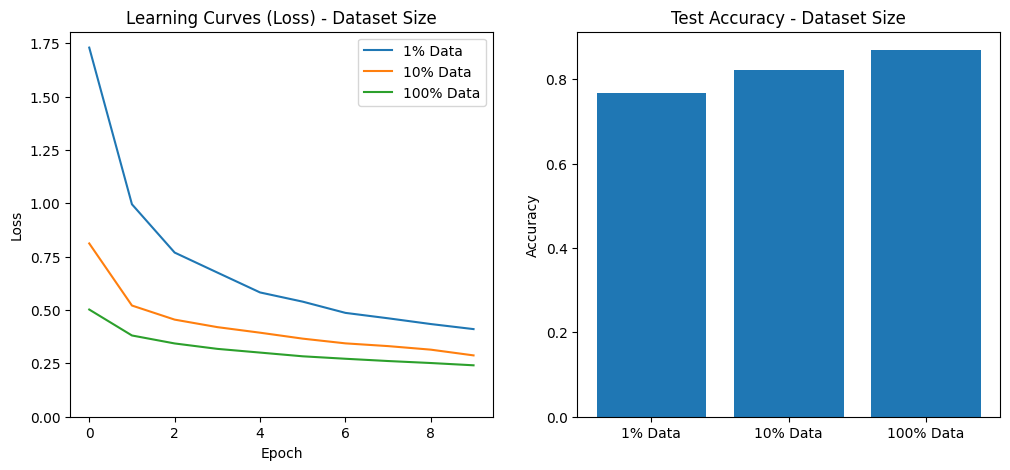

In [17]:
# Eksperyment 3: Rozmiar zbioru uczącego
dataset_fractions = [0.01, 0.1, 1.0]
results_exp3 = {}
fixed_hidden_size = 128
fixed_batch_size = 64

print("\n--- Eksperyment 3: Rozmiar zbioru uczącego ---")

for fraction in dataset_fractions:
    subset_size = int(len(train_dataset) * fraction)
    print(f"Training with {fraction*100}% data ({subset_size} samples)...")
    
    # Tworzenie podzbioru
    indices = np.random.choice(len(train_dataset), subset_size, replace=False)
    subset = torch.utils.data.Subset(train_dataset, indices)
    train_loader_subset = torch.utils.data.DataLoader(subset, batch_size=fixed_batch_size, shuffle=True)
    
    model = NeuralNetwork(hidden_size=fixed_hidden_size, num_hidden_layers=1).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    loss_hist = train_model(model, train_loader_subset, criterion, optimizer, epochs=10)
    acc = evaluate_model(model, test_loader)
    
    results_exp3[f'{int(fraction*100)}% Data'] = {'loss': loss_hist, 'acc': acc}
    print(f"{int(fraction*100)}% Data Accuracy: {acc:.4f}")

# Wizualizacja
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for name, res in results_exp3.items():
    plt.plot(res['loss'], label=name)
plt.title("Learning Curves (Loss) - Dataset Size")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(bottom=0)
plt.legend()

plt.subplot(1, 2, 2)
names = list(results_exp3.keys())
accs = [results_exp3[n]['acc'] for n in names]
plt.bar(names, accs)
plt.title("Test Accuracy - Dataset Size")
plt.ylabel("Accuracy")
plt.show()

### Wnioski - Eksperyment 3
*   **Ilość danych ma kluczowe znaczenie**. Model trenowany na 1% danych osiąga bardzo niską dokładność i prawdopodobnie szybko ulega przeuczeniu (overfitting) - zapamiętuje nieliczne przykłady zamiast uczyć się ogólnych reguł.
*   Wraz ze wzrostem frakcji danych (10% -> 100%), dokładność na zbiorze testowym znacząco rośnie.
*   Pokazuje to, że nawet najlepsza architektura nie pomoże, jeśli nie mamy wystarczającej ilości reprezentatywnych danych treningowych.


--- Eksperyment 4: Odporność na szum ---
Scenario 1: Train Clean, Test Noisy
Epoch 1/10, Loss: 0.4796
Epoch 1/10, Loss: 0.4796
Epoch 2/10, Loss: 0.3754
Epoch 2/10, Loss: 0.3754
Epoch 3/10, Loss: 0.3404
Epoch 3/10, Loss: 0.3404
Epoch 4/10, Loss: 0.3197
Epoch 4/10, Loss: 0.3197
Epoch 5/10, Loss: 0.3035
Epoch 5/10, Loss: 0.3035
Epoch 6/10, Loss: 0.2881
Epoch 6/10, Loss: 0.2881
Epoch 7/10, Loss: 0.2784
Epoch 7/10, Loss: 0.2784
Epoch 8/10, Loss: 0.2686
Epoch 8/10, Loss: 0.2686
Epoch 9/10, Loss: 0.2612
Epoch 9/10, Loss: 0.2612
Epoch 10/10, Loss: 0.2520
Epoch 10/10, Loss: 0.2520
Train Clean, Test Noisy Accuracy: 0.7710
Scenario 2: Train Noisy, Test Noisy
Train Clean, Test Noisy Accuracy: 0.7710
Scenario 2: Train Noisy, Test Noisy
Epoch 1/10, Loss: 0.6007
Epoch 1/10, Loss: 0.6007
Epoch 2/10, Loss: 0.4998
Epoch 2/10, Loss: 0.4998
Epoch 3/10, Loss: 0.4712
Epoch 3/10, Loss: 0.4712
Epoch 4/10, Loss: 0.4547
Epoch 4/10, Loss: 0.4547
Epoch 5/10, Loss: 0.4421
Epoch 5/10, Loss: 0.4421
Epoch 6/10, Loss

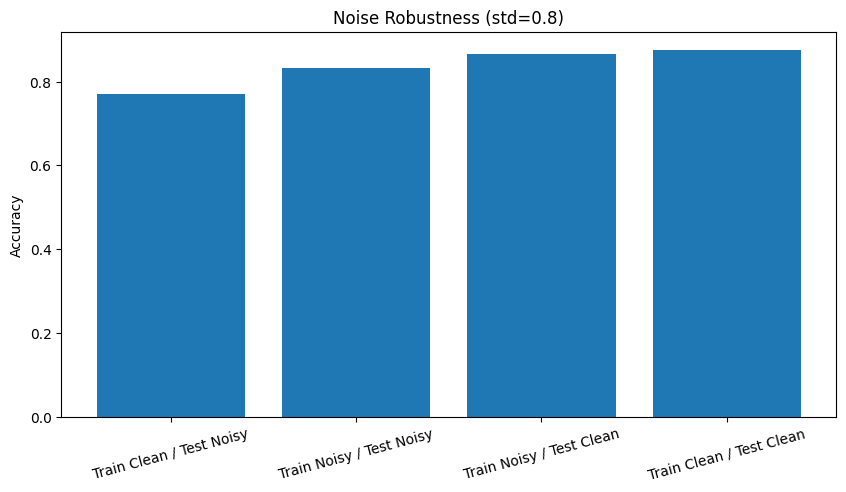

In [18]:
# Eksperyment 4: Zaburzenia danych (Szum Gaussowski)
noise_std = 0.8
results_exp4 = {}

print("\n--- Eksperyment 4: Odporność na szum ---")

# Transformacja z szumem
# Dodajemy szum do tensora
transform_noisy = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * noise_std)
])

# Dataset z szumem (tylko do testów lub treningu w scenariuszu 2)
train_dataset_noisy = torchvision.datasets.FashionMNIST("./data", train=True, download=True, transform=transform_noisy)
test_dataset_noisy = torchvision.datasets.FashionMNIST("./data", train=False, download=True, transform=transform_noisy)

train_loader_noisy = torch.utils.data.DataLoader(train_dataset_noisy, batch_size=64, shuffle=True)
test_loader_noisy = torch.utils.data.DataLoader(test_dataset_noisy, batch_size=64, shuffle=False)

# Scenariusz 1: Trening na czystych danych, test na zaszumionych
print("Scenario 1: Train Clean, Test Noisy")
model_clean = NeuralNetwork(hidden_size=128, num_hidden_layers=1).to(device)
optimizer = optim.Adam(model_clean.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Trenujemy na standardowym train_loader (czyste dane)
train_model(model_clean, train_loader, criterion, optimizer, epochs=10) 
acc_clean_noisy = evaluate_model(model_clean, test_loader_noisy) # Testujemy na zaszumionych
print(f"Train Clean, Test Noisy Accuracy: {acc_clean_noisy:.4f}")
results_exp4['Train Clean / Test Noisy'] = acc_clean_noisy

# Scenariusz 2: Trening na zaszumionych danych, test na zaszumionych
print("Scenario 2: Train Noisy, Test Noisy")
model_noisy = NeuralNetwork(hidden_size=128, num_hidden_layers=1).to(device)
optimizer = optim.Adam(model_noisy.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Trenujemy na train_loader_noisy
train_model(model_noisy, train_loader_noisy, criterion, optimizer, epochs=10) 
acc_noisy_noisy = evaluate_model(model_noisy, test_loader_noisy) # Testujemy na zaszumionych
print(f"Train Noisy, Test Noisy Accuracy: {acc_noisy_noisy:.4f}")
results_exp4['Train Noisy / Test Noisy'] = acc_noisy_noisy

# Scenariusz 3: Trening na zaszumionych danych, test na czystych
print("Scenario 3: Train Noisy, Test Clean")
acc_noisy_clean = evaluate_model(model_noisy, test_loader) # Testujemy na czystych (model_noisy już wytrenowany)
print(f"Train Noisy, Test Clean Accuracy: {acc_noisy_clean:.4f}")
results_exp4['Train Noisy / Test Clean'] = acc_noisy_clean

# Baseline: Train Clean, Test Clean (dla odniesienia)
acc_clean_clean = evaluate_model(model_clean, test_loader)
results_exp4['Train Clean / Test Clean'] = acc_clean_clean

# Wizualizacja
plt.figure(figsize=(10, 5))
plt.bar(results_exp4.keys(), results_exp4.values())
plt.title(f"Noise Robustness (std={noise_std})")
plt.ylabel("Accuracy")
plt.xticks(rotation=15)
plt.show()

### Wnioski - Eksperyment 4
*   **Train Clean / Test Noisy**: Model nauczony na czystych danych kompletnie gubi się przy zaszumionych danych wejściowych. To pokazuje brak odporności na zmiany w rozkładzie danych (domain shift).
*   **Train Noisy / Test Noisy**: Trenowanie na zaszumionych danych pozwala modelowi "zrozumieć" szum i ignorować go, co drastycznie poprawia wynik na zaszumionym zbiorze testowym.
*   **Train Noisy / Test Clean**: Model uczony na szumie często radzi sobie całkiem nieźle na czystych danych (czasem szum działa jak regularyzacja), choć może być nieco gorszy od modelu trenowanego specyficznie na czystych danych.